# Library Import

In [85]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')


# Utils

In [86]:
class TransparentLabelEncoder:
    def __init__(self, mapping_dict):
        self.mapping_dict = mapping_dict
        self.reverse_mapping_dict = {v: k for k, v in mapping_dict.items()}
    
    def transform(self, X):
        return X.map(self.mapping_dict)
    
    def fit_transform(self, X):
        return self.transform(X)
    
    def inverse_transform(self, X_encoded):
        return X_encoded.map(self.reverse_mapping_dict)

def classify_bmi(bmi):
    if bmi < 16:
        return 'Severe Thinness'
    elif 16 <= bmi < 17:
        return 'Moderate Thinness'
    elif 17 <= bmi < 18.5:
        return 'Mild Thinness'
    elif 18.5 <= bmi < 25:
        return 'Healthy'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obesity Grade I'
    elif 35 <= bmi < 40:
        return 'Obesity Grade II'
    else:
        return 'Obesity Grade III'

# Loading the Database

In [87]:
data = pd.read_csv('data/train.csv')
data['FHWO'] = data['family_history_with_overweight']
data.drop(columns=['family_history_with_overweight'], inplace=True)
display(data.head())


,id,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,FHWO
0,0,Male,24.443011,1.699998,81.669950,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,yes
1,1,Female,18.000000,1.560000,57.000000,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,yes
2,2,Female,18.000000,1.711460,50.165754,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,yes
3,3,Female,20.952737,1.710730,131.274851,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,yes
4,4,Male,31.641081,1.914186,93.798055,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,yes


# Getting to Know the Data

In [88]:
print("Tipos de dados presentes na base:")
print(data.dtypes)

print("\nMedidas estatísticas básicas:")
print(data.describe())

print("\nNúmero de valores únicos para atributos categóricos:")
categorical_attributes = data.select_dtypes(include=['object'])
print(data.select_dtypes(include=['object']).nunique())

print("\nValores ausentes por atributo:")
print(data.isnull().sum())

Tipos de dados presentes na base:
id              int64
Gender         object
Age           float64
Height        float64
Weight        float64
FAVC           object
FCVC          float64
NCP           float64
CAEC           object
SMOKE          object
CH2O          float64
SCC            object
FAF           float64
TUE           float64
CALC           object
MTRANS         object
NObeyesdad     object
FHWO           object
dtype: object

Medidas estatísticas básicas:
                id           Age        Height        Weight          FCVC  \
count  20758.00000  20758.000000  20758.000000  20758.000000  20758.000000   
mean   10378.50000     23.841804      1.700245     87.887768      2.445908   
std     5992.46278      5.688072      0.087312     26.379443      0.533218   
min        0.00000     14.000000      1.450000     39.000000      1.000000   
25%     5189.25000     20.000000      1.631856     66.000000      2.000000   
50%    10378.50000     22.815416      1.700000     84.064

# Feature Explanation

- **CALC**: Binary indicator of alcohol intake with two levels: "Yes" (positive alcohol intake) and "No" (zero alcohol intake).
- **TUE**: Time spent on technological devices.
- **FAF**: Frequency of physical activity.
- **SCC**: Binary indicator of food calorie monitoring with two levels: "Yes" and "No".
- **CH2O**: Amount of daily water intake in liters.
- **SMOKE**: Binary indicator of smoking with two levels: "Yes" (smoke) and "No" (never smoke).
- **MTRANS**: The usual means of transportation and consists of five levels: Automobile, Motorbike, Bike, Public Transportation and Walking. 
- **CAEC**: Frequency of sub-meals between main meals with four levels: "No", "Sometimes", "Frequently", and "Always".
- **NCP**: Number of main meals in a day.
- **FCVC**: Frequency of vegetable intake in meals. Values greater than 2 indicate positive vegetable intake in every meal, while values less than or equal to 2 indicate zero vegetable intake for some meals.
- **FAVC**: Frequency of consuming high-calorie foods with two levels: "Yes" (high-frequency) and "No" (low-frequency intake of high caloric foods).
- **FHWO**: Family history with overweight, indicating whether family members have histories of obesity, with two levels: "Yes" and "No". 
- **Age, gender, height, and weight** are also recorded.

# Feature Engineering

## Explanation

- **BMI (Body Mass Index)**: Since we have the values of individuals' weight and height, we can calculate the BMI value, which is given by BMI = weight / (height)^2. This indicator can be useful in determining body health.

- **Class_BMI**: The BMI classification is a categorical attribute that uses BMI to define individuals' body health, as illustrated in the explanation below:
    - Less than 16 - Severe Thinness
    - 16 to less than 17 - Moderate Thinness
    - 17 to less than 18.5 - Mild Thinness
    - 18.5 to less than 25 - Healthy
    - 25 to less than 30 - Overweight
    - 30 to less than 35 - Obesity Grade I
    - 35 to less than 40 - Obesity Grade II (considered severe)
    - Greater than 40 - Obesity Grade III (considered morbid)
    - Reference: https://www.tjdft.jus.br/informacoes/programas-projetos-e-acoes/pro-vida/dicas-de-saude/pilulas-de-saude/o-que-o-indice-de-massa-corporal-imc-diz-sobre-sua-saude#:~:text=Criado%20no%20s%C3%A9culo%2019%20pelo,n%C3%A3o%20com%20o%20peso%20ideal.&text=Muitas%20pessoas%20buscam%20descobrir%20seu,espec%C3%ADfica%20ou%20uma%20atividade%20f%C3%ADsica.

- **WIPKg (Water Intake Per Kg)**: Water intake per kg of body weight. Formula: ['CH2O'] / ['Weight']

- **WIPKgFAF (Water Intake Per Kg and FAF)**: Interaction feature between the frequency of physical activity and water consumption. This attribute was created with the intention that if the individual tends to engage in physical activities, they are likely to become more dehydrated and need to ingest more liquid to recover. Formula: ['CH2O'] / ['FAF'] + ['Weight']

- **QVPD (Quantity of Vegetable Per Day)**: Measures the quantity of vegetables consumed per day. Formula: ['NCP'] * ['FCVC']

- **TPAS (Total Physical Activity Score)**: I decided to assign a physical activity score using the difference between the frequency of physical activities and the time spent on electronic devices. Formula: ['FAF'] - ['TUE']


## Implementation

In [89]:
data['WINPKg'] = data['CH2O'] / data['Weight']
data['BMI'] = data['Weight'] / (data['Height'])**2
data['Class_BMI'] = data['BMI'].apply(classify_bmi)
data['QVPD'] = data['NCP'] * (data['FCVC'])
data['WINPKgFAF'] =  data['CH2O']/(data['FAF'] + data['Weight'])
data['TPAS'] = data['FAF'] - data['TUE']
display(data.head())

,id,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,MTRANS,NObeyesdad,FHWO,WINPKg,BMI,Class_BMI,QVPD,WINPKgFAF,TPAS
0,0,Male,24.443011,1.699998,81.669950,yes,2.000000,2.983297,Sometimes,no,...,Sometimes,Public_Transportation,Overweight_Level_II,yes,0.033838,28.259565,Overweight,5.966594,0.033838,-0.976473
1,1,Female,18.000000,1.560000,57.000000,yes,2.000000,3.000000,Frequently,no,...,no,Automobile,Normal_Weight,yes,0.035088,23.422091,Healthy,6.000000,0.034483,0.000000
2,2,Female,18.000000,1.711460,50.165754,yes,1.880534,1.411685,Sometimes,no,...,no,Public_Transportation,Insufficient_Weight,yes,0.038081,17.126706,Mild Thinness,2.654722,0.037435,-0.807539
3,3,Female,20.952737,1.710730,131.274851,yes,3.000000,3.000000,Sometimes,no,...,Sometimes,Public_Transportation,Obesity_Type_III,yes,0.012752,44.855798,Obesity Grade III,9.000000,0.012611,0.687664
4,4,Male,31.641081,1.914186,93.798055,yes,2.679664,1.971472,Sometimes,no,...,Sometimes,Public_Transportation,Overweight_Level_II,yes,0.021108,25.599151,Overweight,5.282883,0.020674,1.036252


# Data Visualization

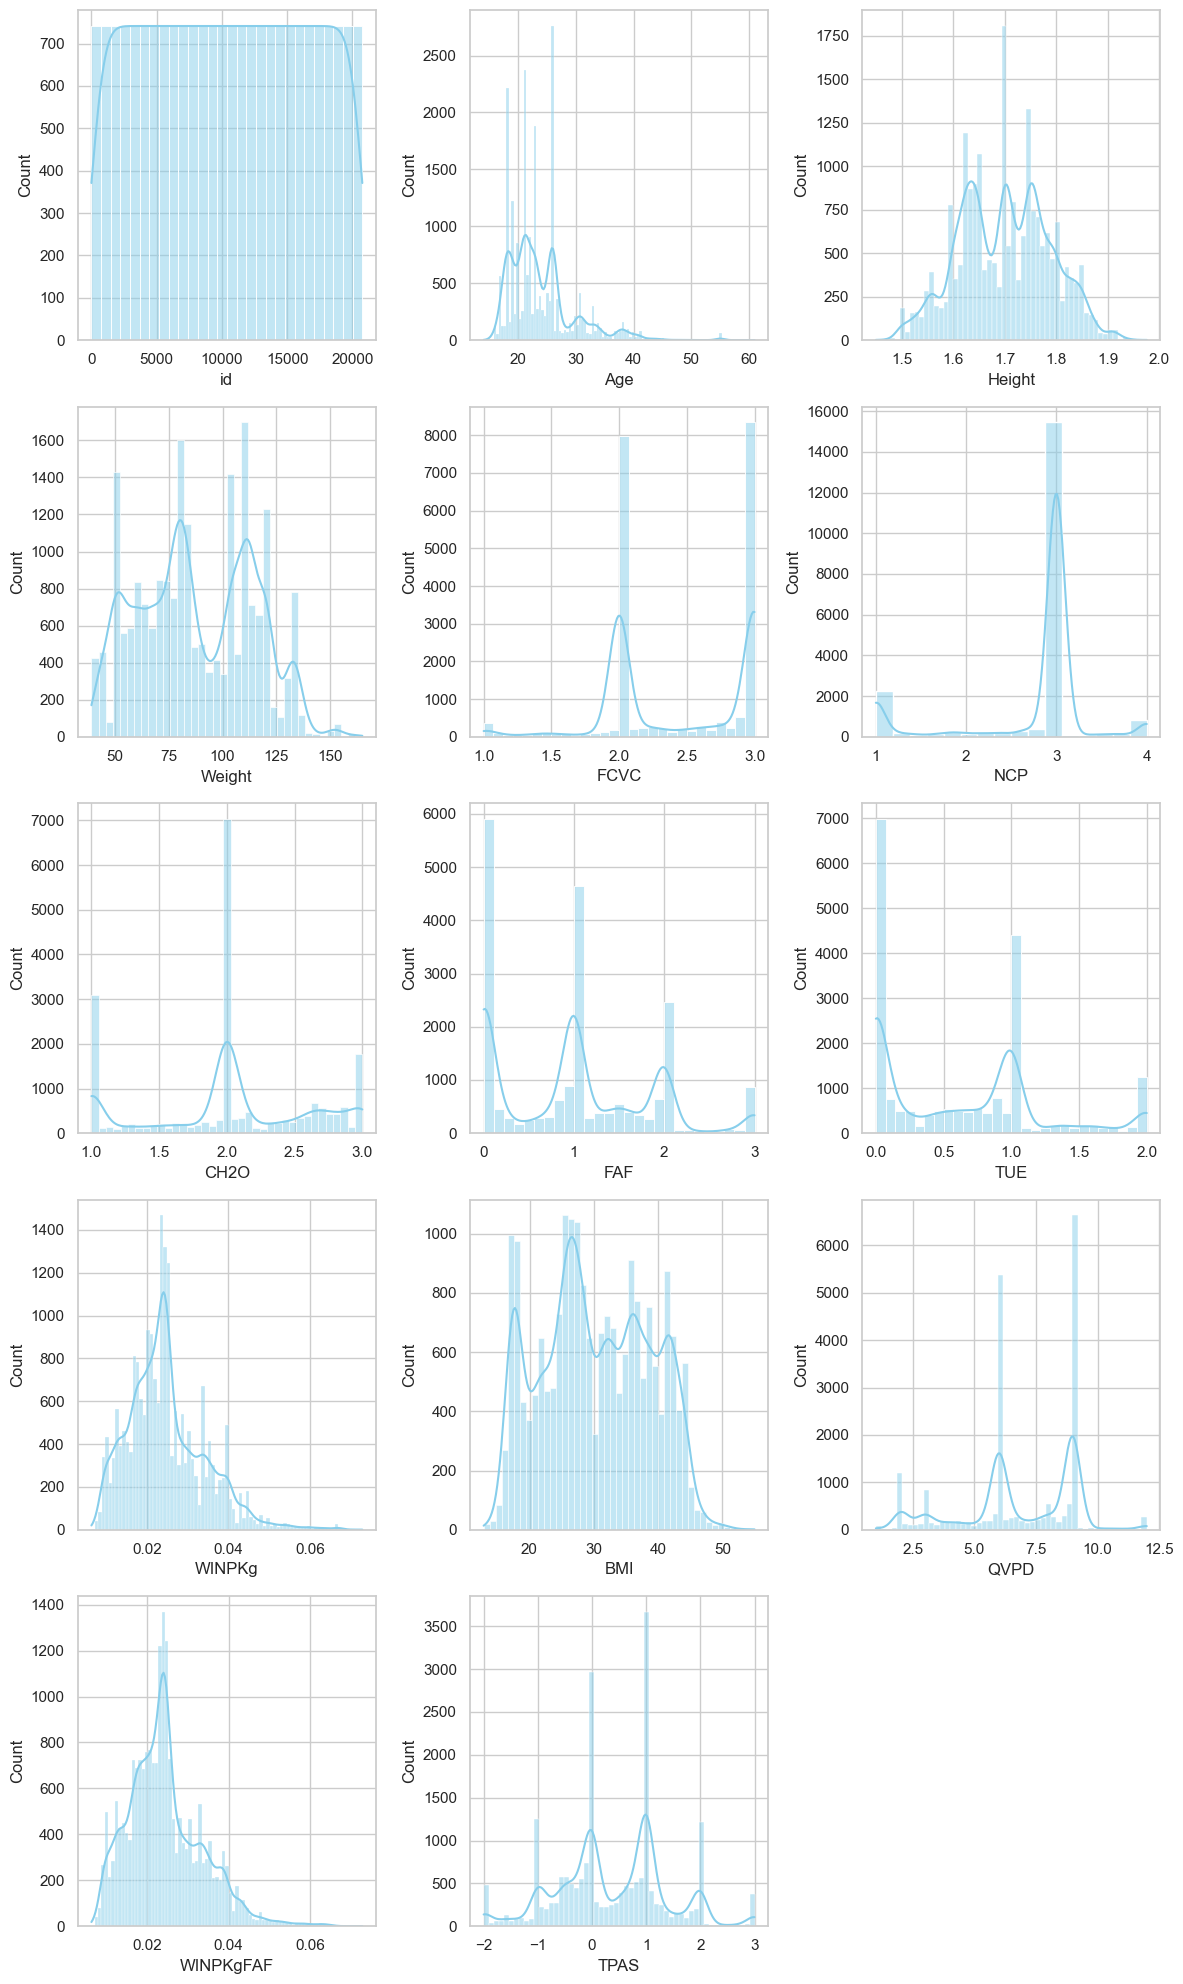

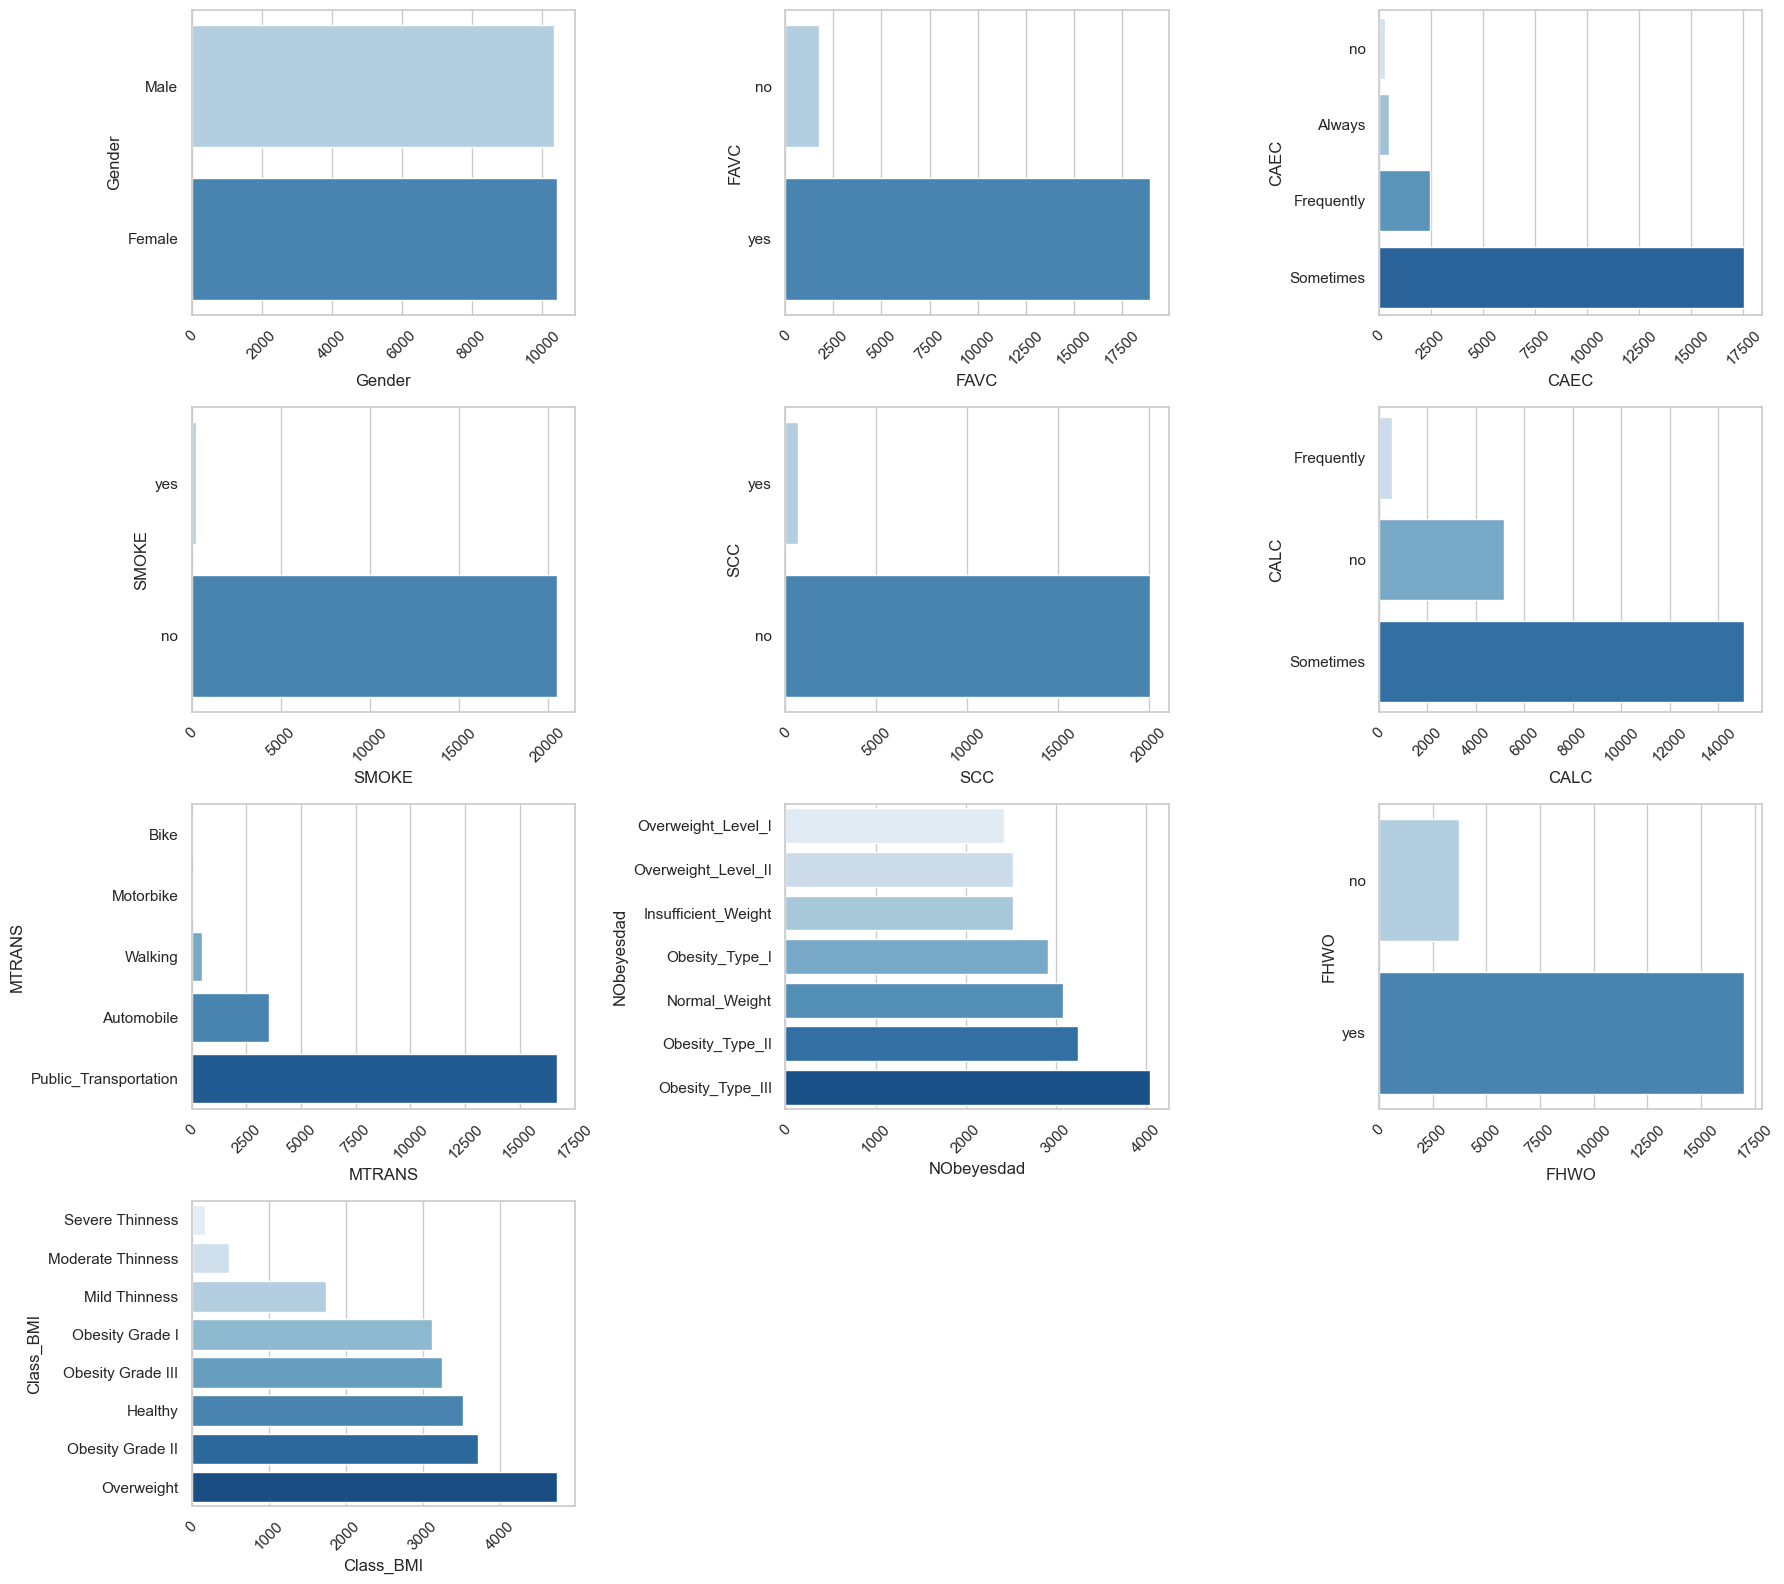

In [90]:
numeric_attributes = data.select_dtypes(include=['int', 'float'])
num_attributes = len(numeric_attributes.columns)
num_rows = math.ceil(num_attributes / 3)
num_cols = min(num_attributes, 3)
sns.set(style="whitegrid") 
plt.figure(figsize=(12, 4*num_rows))  

for i, col in enumerate(numeric_attributes.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(data[col], kde=True, color='skyblue')
    plt.xlabel(col)

plt.tight_layout() 
plt.show()

# Define as colunas categóricas
categorical_attributes = data.select_dtypes(include=['object'])
num_attributes = len(categorical_attributes.columns)
num_rows = math.ceil(num_attributes / 3)
num_cols = min(num_attributes, 3)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4*num_rows))  # Define o tamanho da figura

for i, col in enumerate(categorical_attributes.columns):
    if i < num_attributes:
        ax = axes[i // num_cols, i % num_cols] 
        order = data[col].value_counts().index[::-1]
   
        sns.countplot(data=data, y=col, palette="Blues", ax=ax, order=order)
        ax.set_xlabel(col)
        ax.tick_params(axis='x', rotation=45)
    else:
        break  

for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()


# Encoding categorical attributes

I initially chose to use the LabelEncoder class from the sklearn library. However, I would like to have more transparency in this process and know exactly how this determination was made. Therefore, create my own attribute encoder.

## Defining coding labels

In [91]:
mapping_binary_dict = {"no": 0, 
                       "yes": 1}

mapping_gender_dict = {"Female": 0, 
                       "Male": 1}

mapping_frequency_dict = {"no": 0, 
                          "Sometimes": 1, 
                          "Frequently": 2, 
                          "Always": 3}

mapping_Class_BMI_dict = {"Severe Thinness": 0, 
                          "Moderate Thinness": 1, 
                          "Mild Thinness": 2, 
                          "Healthy": 3,  
                          "Overweight": 4,  
                          "Obesity Grade I": 5, 
                          "Obesity Grade II": 6, 
                          "Obesity Grade III": 7 }

mapping_NObeyesdad_dict = {"Insufficient_Weight": 0, 
                          "Normal_Weight": 1, 
                          "Overweight_Level_I": 2, 
                          "Overweight_Level_II": 3,  
                          "Obesity_Type_I": 4,  
                          "Obesity_Type_II": 5, 
                          "Obesity_Type_III": 6}

mapping_MTRANS_dict = {"Walking": 0, 
                          "Bike": 1, 
                          "Motorbike": 2, 
                          "Automobile": 3,
                          "Public_Transportation": 4}



## Implementation

In [92]:
binary_label_encoder = TransparentLabelEncoder(mapping_binary_dict)
gender_label_encoder = TransparentLabelEncoder(mapping_gender_dict)
freq_label_encoder = TransparentLabelEncoder(mapping_frequency_dict)
label_encoder_Class_BMI = TransparentLabelEncoder(mapping_Class_BMI_dict)
label_encoder_NObeyesdad = TransparentLabelEncoder(mapping_NObeyesdad_dict)
label_encoder_MTRANS = TransparentLabelEncoder(mapping_MTRANS_dict)

data["FHWO"] = binary_label_encoder.fit_transform(data["FHWO"])
data["FAVC"] = binary_label_encoder.fit_transform(data["FAVC"])
data["SMOKE"] = binary_label_encoder.fit_transform(data["SMOKE"])
data["SCC"] = binary_label_encoder.fit_transform(data["SCC"])
data["Gender"] = gender_label_encoder.fit_transform(data['Gender'])
data["CALC"] = freq_label_encoder.fit_transform(data["CALC"])
data["CAEC"] = freq_label_encoder.fit_transform(data["CAEC"])
data["Class_BMI"] = label_encoder_Class_BMI.fit_transform(data["Class_BMI"])
data["NObeyesdad"] = label_encoder_NObeyesdad.fit_transform(data["NObeyesdad"])
data["MTRANS"] = label_encoder_MTRANS.fit_transform(data["MTRANS"])

In [93]:
data.head()

,id,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,MTRANS,NObeyesdad,FHWO,WINPKg,BMI,Class_BMI,QVPD,WINPKgFAF,TPAS
0,0,1,24.443011,1.699998,81.669950,1,2.000000,2.983297,1,0,...,1,4,3,1,0.033838,28.259565,4,5.966594,0.033838,-0.976473
1,1,0,18.000000,1.560000,57.000000,1,2.000000,3.000000,2,0,...,0,3,1,1,0.035088,23.422091,3,6.000000,0.034483,0.000000
2,2,0,18.000000,1.711460,50.165754,1,1.880534,1.411685,1,0,...,0,4,0,1,0.038081,17.126706,2,2.654722,0.037435,-0.807539
3,3,0,20.952737,1.710730,131.274851,1,3.000000,3.000000,1,0,...,1,4,6,1,0.012752,44.855798,7,9.000000,0.012611,0.687664
4,4,1,31.641081,1.914186,93.798055,1,2.679664,1.971472,1,0,...,1,4,3,1,0.021108,25.599151,4,5.282883,0.020674,1.036252


## Correlation plot

I chose Spearman's correlation because it is a non-parametric measure of correlation that assesses the monotonicity of the relationship between two variables. It is more suitable for data that does not follow a normal distribution or when there are outliers present. In addition, while Pearson's correlation only evaluates the linear relationship between two variables, Spearman's correlation can detect monotonic relationships, whether they are linear or not.

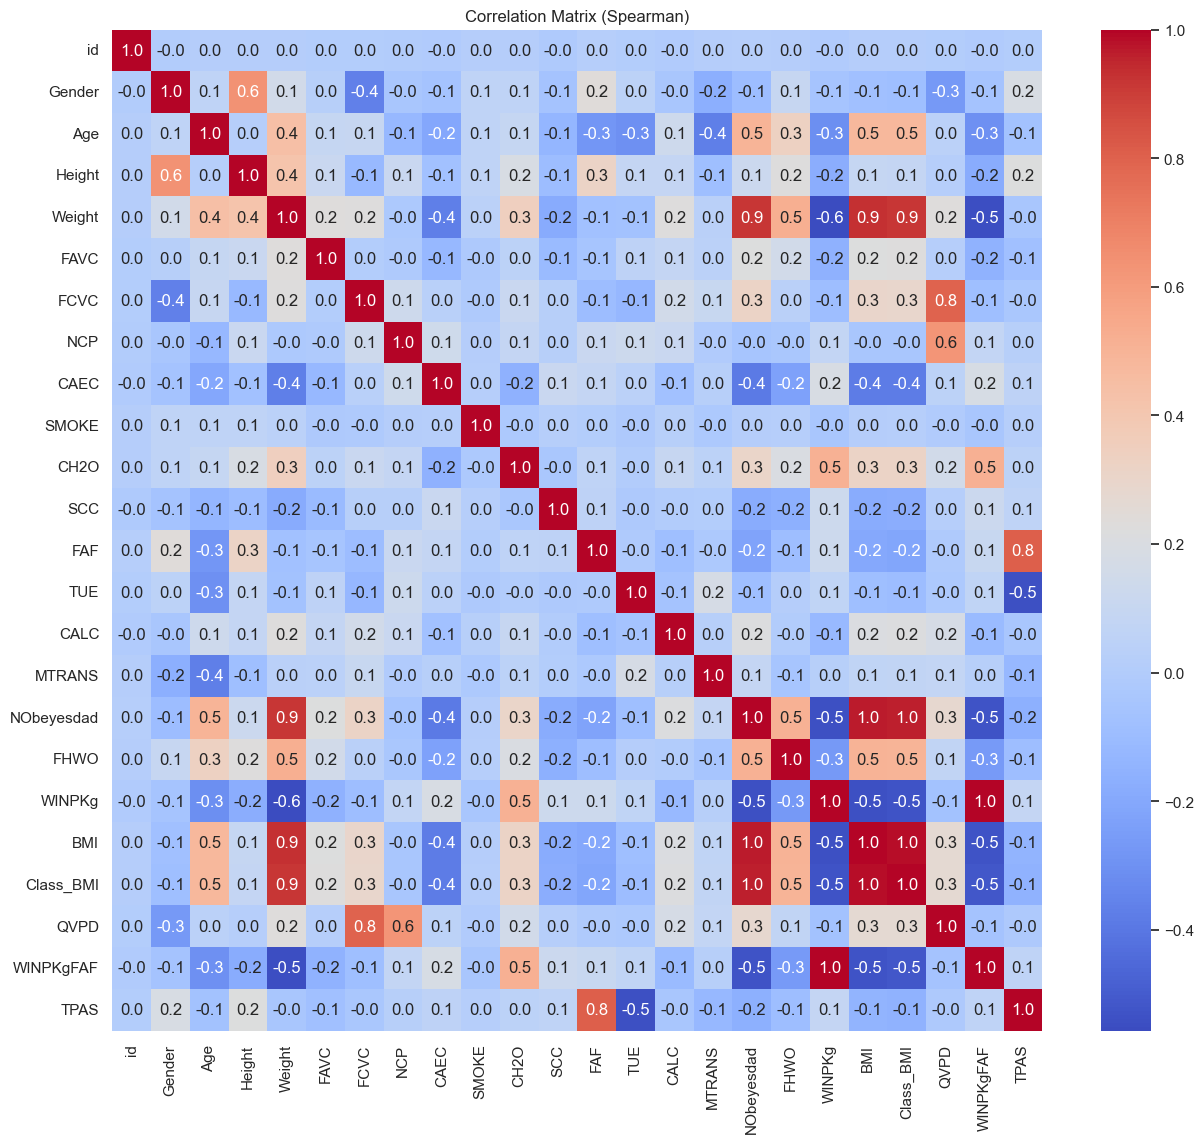

In [94]:
correlation_matrix_spearman = data.corr(method='spearman')

plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix (Spearman)')
plt.show()

We noticed that the variables created are strongly correlated with the objective variable. This can be very helpful in resolving the problem. We can also see that some of these input variables also have a strong correlation with other input variables. However, there is no need to exclude one of these variables to improve the model.

# Data Transformation

As we observed in the visualizations under the ***Visualization*** topic, none of the attributes follow a normal distribution. Therefore, I decided to use the PowerTransformer class from sklearn to improve the normality and homogeneity of the data.

In [95]:
pt = PowerTransformer(method='yeo-johnson')
train_features = data.drop(columns=['id', 'NObeyesdad'], axis=1)
train_features_scaled = pt.fit_transform(train_features)

train_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns)
train_scaled['NObeyesdad'] = data['NObeyesdad']
train_scaled['id'] = data['id']
display(train_scaled)

,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,...,MTRANS,FHWO,WINPKg,BMI,Class_BMI,QVPD,WINPKgFAF,TPAS,NObeyesdad,id
0,1.004152,0.392273,0.001826,-0.180944,0.30588,-0.882621,0.182365,-0.263581,-0.109287,1.232230,...,0.493485,0.469099,1.039920,-0.195655,-0.339855,-0.444862,1.088120,-1.323196,3,0
1,-0.995866,-1.379784,-1.613755,-1.189908,0.30588,-0.882621,0.217247,1.827186,-0.109287,-0.084861,...,-1.985641,0.469099,1.144514,-0.799525,-0.921968,-0.430818,1.143557,-0.345338,1,1
2,-0.995866,-1.379784,0.133016,-1.495630,0.30588,-1.077494,-1.817734,-0.263581,-0.109287,-0.232407,...,0.493485,0.469099,1.379628,-1.645399,-1.485057,-1.647590,1.384353,-1.152373,0,2
3,-0.995866,-0.403279,0.124665,1.562234,0.30588,1.072753,0.217247,-0.263581,-0.109287,-0.613803,...,0.493485,0.469099,-1.483546,1.674900,1.491623,0.964131,-1.490759,0.326303,6,3
4,1.004152,1.384082,2.427755,0.274031,0.30588,0.383134,-1.357225,-0.263581,-0.109287,-0.118174,...,0.493485,0.469099,-0.286130,-0.523527,-0.339855,-0.724498,-0.313409,0.662487,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1.004152,0.518774,0.762210,0.993953,0.30588,0.894011,0.217247,-0.263581,-0.109287,0.168581,...,0.493485,0.469099,-0.580694,0.775512,0.868936,0.842683,-0.585554,0.756196,5,20753
20754,1.004152,-1.379784,0.116314,-1.503223,0.30588,1.072753,3.013471,1.827186,-0.109287,-1.635368,...,0.493485,-2.131745,-0.427744,-1.649268,-1.485057,2.597236,-0.503569,0.627633,0,20754
20755,1.004152,-0.649421,1.362528,0.696208,0.30588,-0.155265,0.217247,-0.263581,-0.109287,-0.084861,...,0.493485,0.469099,-0.567469,0.237103,0.257883,0.106920,-0.570515,-0.385249,5,20755
20756,1.004152,1.587449,0.001848,-0.110046,0.30588,0.365801,-1.357225,-0.263581,-0.109287,0.156848,...,-1.985641,0.469099,0.250301,-0.118179,-0.339855,-0.731104,0.285725,-1.320523,3,20756


# Redução de dimensionalidade

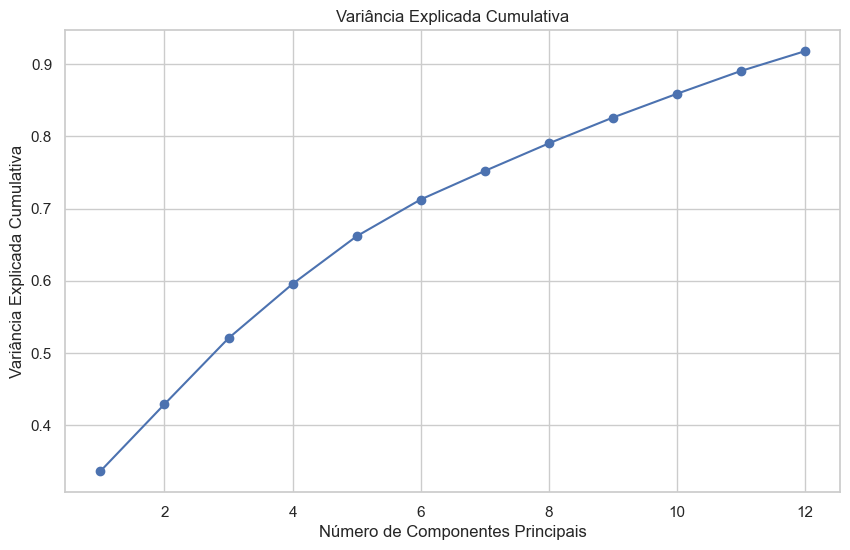

,0,1,2,3,4,5,6,7,8,9,10,11,NObeyesdad,id
0,0.509427,-0.728518,-0.071800,-2.344534,-1.175212,1.368310,0.250562,-0.447788,-0.111303,-0.084398,-0.079419,-0.160168,3,0
1,3.655918,-0.791707,-0.599615,-0.538522,0.080989,0.929829,-1.545265,1.340800,0.550908,1.175402,-0.866417,1.536286,1,1
2,4.680346,-0.171189,-1.654210,-2.537054,-1.119014,-0.780875,-0.774393,0.658586,0.605262,0.531004,0.173795,-0.434633,0,2
3,-4.219781,-0.413683,0.075466,1.697750,-0.547584,-1.540066,-0.120483,-0.017662,-0.022734,-0.055234,0.100139,0.549758,6,3
4,-0.197880,2.355908,0.661098,-0.396907,-0.717822,-0.225661,0.279512,-0.504759,-0.070521,-0.239110,-0.533115,-1.489847,3,4


(20758, 14)

In [96]:
# Aplicando o PCA
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(train_scaled.drop(columns=['id']))

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plotando a variância explicada cumulativa
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
plt.title('Variância Explicada Cumulativa')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Cumulativa')
plt.grid(True)
plt.show()

df_pca = pd.DataFrame(data=X_pca)
df_pca['NObeyesdad'] = train_scaled['NObeyesdad']
df_pca['id'] = train_scaled['id']
display(df_pca.head())
display(df_pca.shape)


I even tested the prediction algorithms with dimensionality reduction, but there was no improvement for the problem.

# Modelos

In [97]:
X = train_scaled.drop(columns=['NObeyesdad', 'id'], axis=1)
y = train_scaled['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes

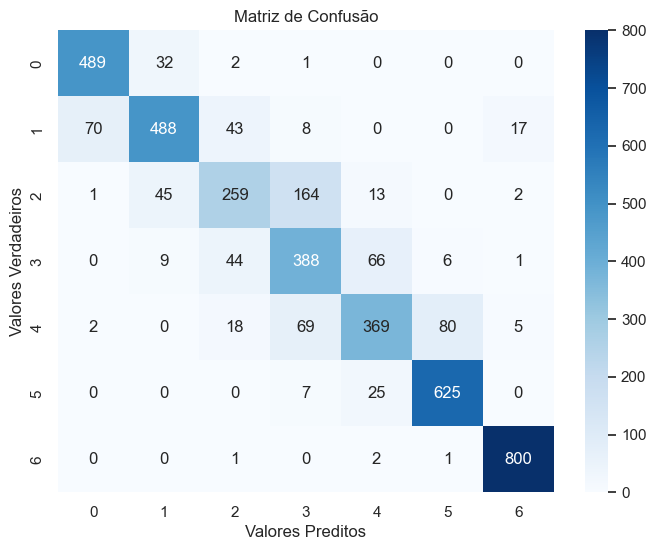

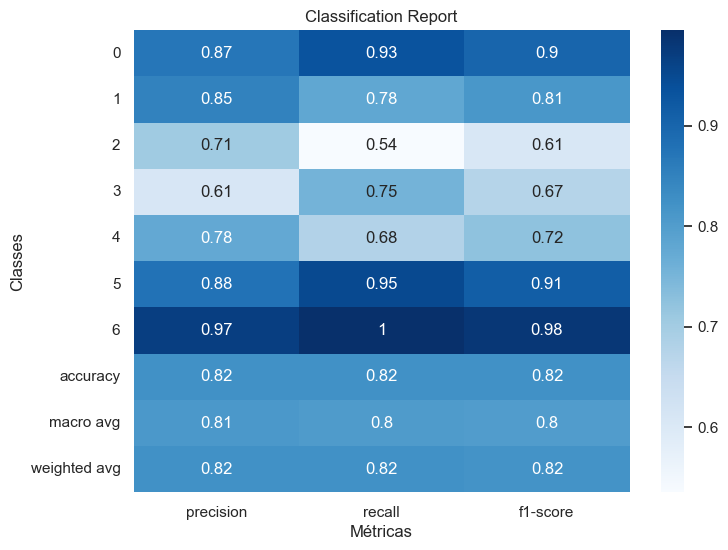

Accuracy: 0.8232177263969171


In [98]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.xlabel('Métricas')
plt.ylabel('Classes')
plt.show()
print('Accuracy:', accuracy_score(y_test, y_pred_nb))

## Random Forest Classifier

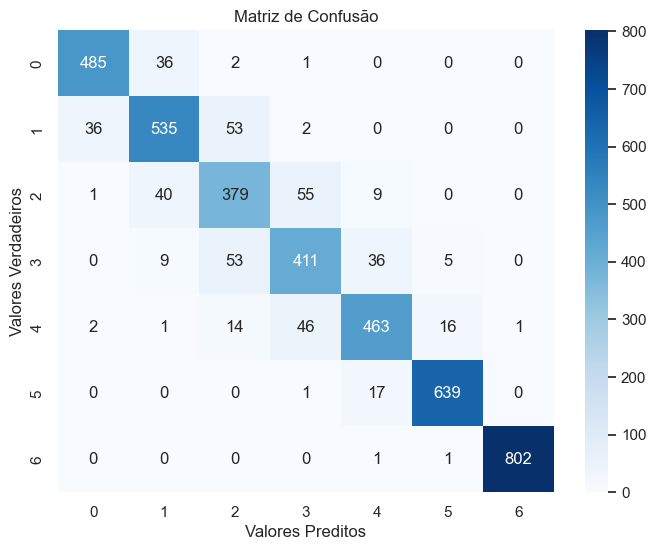

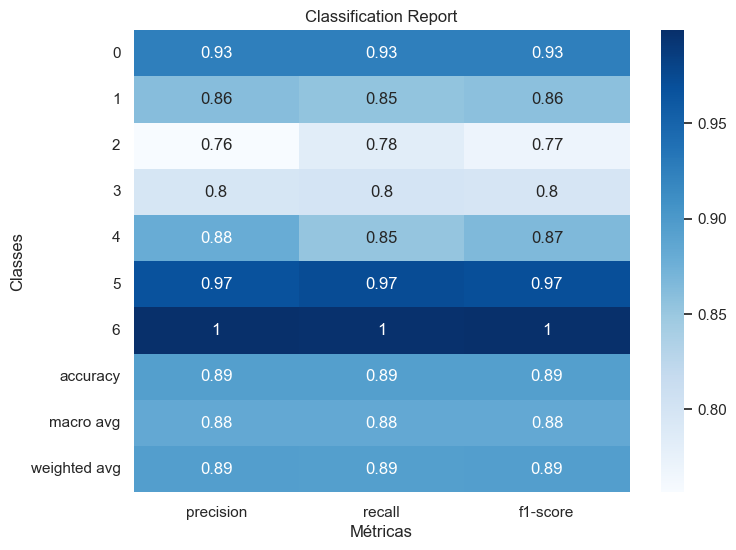

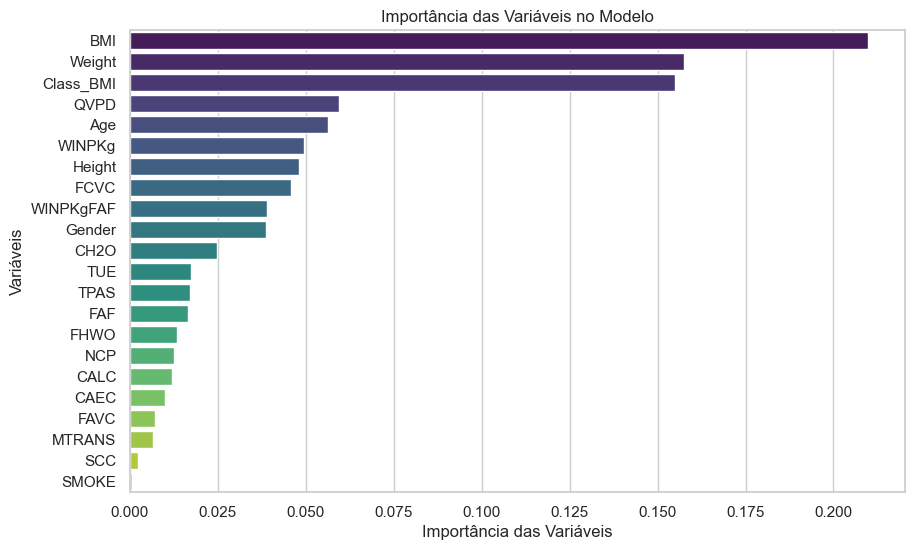

Accuracy: 0.8945086705202312


In [99]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1,
                              criterion='gini', bootstrap=True,
                             class_weight=None, ccp_alpha=0.0, max_samples=None)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.xlabel('Métricas')
plt.ylabel('Classes')
plt.show()

importance = rf.feature_importances_
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[indices], y=X_train.columns[indices], palette="viridis")
plt.xlabel('Importância das Variáveis')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis no Modelo')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred_rf))

## XGB Classifier

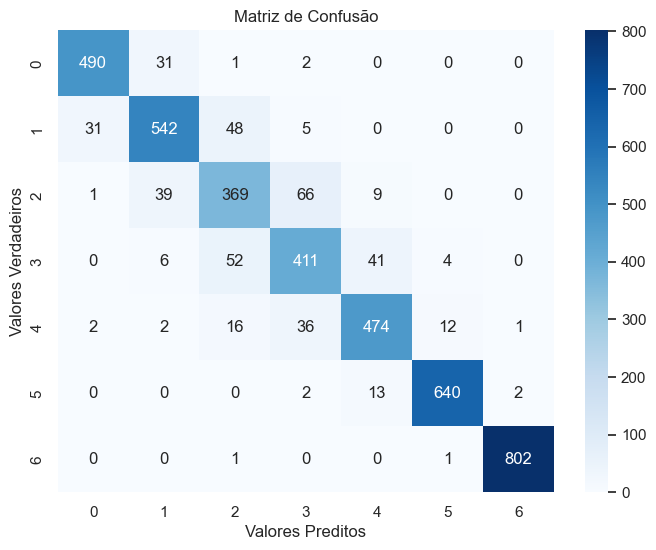

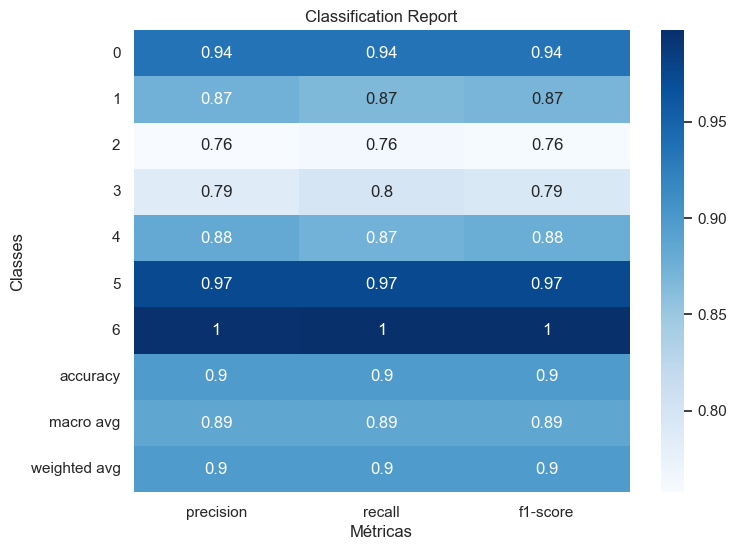

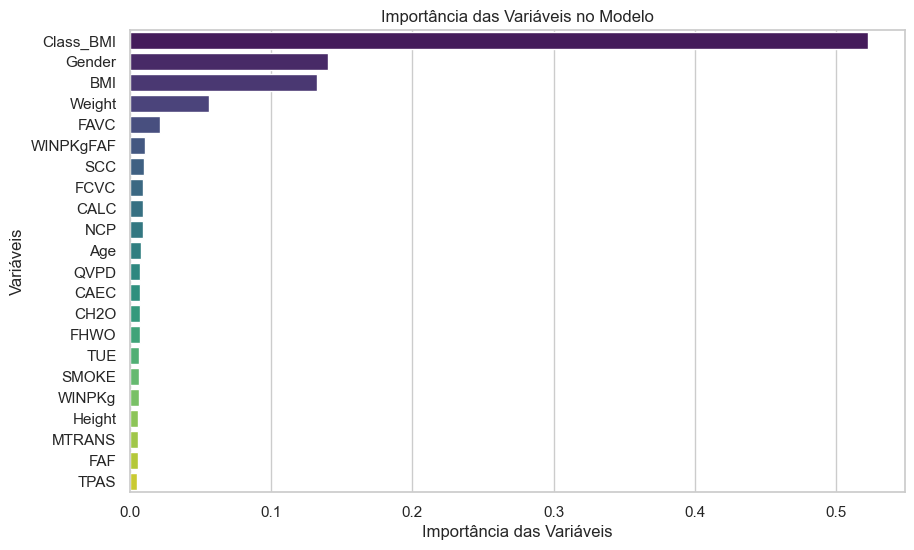

Accuracy: 0.8978805394990366


In [100]:
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=20, min_samples_split=2, min_samples_leaf=1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Verdadeiros')
plt.show()

# Plotando o classification report
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred_xgb, output_dict=True)).iloc[:-1, :].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.xlabel('Métricas')
plt.ylabel('Classes')
plt.show()


# Plotando as importâncias das variáveis
importance = xgb.feature_importances_
indices = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[indices], y=X_train.columns[indices], palette="viridis")
plt.xlabel('Importância das Variáveis')
plt.ylabel('Variáveis')
plt.title('Importância das Variáveis no Modelo')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred_xgb))

# Comparação de modelos

## Naive Bayes vs Random Forest vs XGB

In [101]:
# Comparando os resultados com o modelo RandomForest
print('\nComparação de Resultados:')
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred_nb))
print('XGB Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('RandomForest Accuracy:', accuracy_score(y_test, y_pred_rf))


Comparação de Resultados:
Naive Bayes Accuracy: 0.8232177263969171
XGB Accuracy: 0.8978805394990366
RandomForest Accuracy: 0.8945086705202312


# Submissão de resultados

In [102]:
data_test = pd.read_csv('data/test.csv')
data_test['FHWO'] = data_test['family_history_with_overweight']
data_test.drop(columns=['family_history_with_overweight'], inplace=True)

data_test['WINPKg'] = data_test['CH2O'] / data_test['Weight']
data_test['BMI'] = data_test['Weight'] / (data_test['Height'])**2
data_test['Class_BMI'] = data_test['BMI'].apply(classify_bmi)
data_test['QVPD'] = data_test['NCP'] * (data_test['FCVC'])
data_test['WINPKgFAF'] =  data_test['CH2O']/(data_test['FAF'] + data_test['Weight'])
data_test['TPAS'] = data_test['FAF'] - data_test['TUE']

data_test["FHWO"] = binary_label_encoder.fit_transform(data_test["FHWO"])
data_test["FAVC"] = binary_label_encoder.fit_transform(data_test["FAVC"])
data_test["SMOKE"] = binary_label_encoder.fit_transform(data_test["SMOKE"])
data_test["SCC"] = binary_label_encoder.fit_transform(data_test["SCC"])
data_test["Gender"] = gender_label_encoder.fit_transform(data_test['Gender'])
data_test["CALC"] = freq_label_encoder.fit_transform(data_test["CALC"])
data_test["CAEC"] = freq_label_encoder.fit_transform(data_test["CAEC"])
data_test["Class_BMI"] = label_encoder_Class_BMI.fit_transform(data_test["Class_BMI"])
data_test["MTRANS"] = label_encoder_MTRANS.fit_transform(data_test["MTRANS"])

pt_test = PowerTransformer(method='yeo-johnson')
test_features = data_test.drop(columns=['id'], axis=1)
test_features_scaled = pt_test.fit_transform(test_features)

test_scaled = pd.DataFrame(test_features_scaled, columns=test_features.columns)
test_scaled['id'] = data_test['id']
display(test_scaled)

,Gender,Age,Height,Weight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,...,CALC,MTRANS,FHWO,WINPKg,BMI,Class_BMI,QVPD,WINPKgFAF,TPAS,id
0,1.006524,0.778379,1.657039,1.240840,0.316064,0.944503,0.233107,-0.26682,-0.114792,1.329053,...,0.431106,0.495288,0.464480,-0.025493,0.648884,0.885035,0.892746,-0.013905,0.495068,20758
1,-0.993518,-0.405050,-1.118743,-0.795210,0.316064,-0.876850,-2.009124,-0.26682,-0.114792,1.641252,...,0.431106,0.495288,0.464480,1.845303,-0.491160,-0.324310,-1.834289,1.867652,0.634652,20759
2,-0.993518,0.639124,-0.617256,0.930964,0.316064,1.080544,0.233107,-0.26682,-0.114792,0.969940,...,0.431106,0.495288,0.464480,-0.017137,1.320393,1.506293,0.985063,0.013954,-0.594049,20760
3,1.006524,-0.410643,-1.669500,0.651833,0.316064,-0.876850,0.187104,-0.26682,-0.114792,1.259459,...,0.431106,0.495288,0.464480,0.354844,1.499927,1.506293,-0.427195,0.388493,-0.248921,20761
4,-0.993518,0.639124,-0.800983,0.693336,0.316064,1.080544,0.233107,-0.26682,-0.114792,1.025319,...,0.431106,0.495288,0.464480,0.187353,1.129088,0.885035,0.985063,0.221203,-1.091982,20762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,1.006524,0.147945,0.266861,-0.307365,-3.163912,0.673078,0.233107,-0.26682,-0.114792,-1.636675,...,0.431106,0.495288,0.464480,-1.472780,-0.422097,-0.324310,0.706808,-1.477629,-0.314871,34593
13836,-0.993518,1.063248,-1.235486,-0.964182,0.316064,1.080544,0.233107,-0.26682,-0.114792,-0.085701,...,0.431106,0.495288,-2.152947,0.873872,-0.649978,-0.908721,0.985063,0.918470,-0.343181,34594
13837,-0.993518,0.064153,-1.287602,-1.760037,0.316064,1.080544,-0.987281,1.80452,-0.114792,-0.085701,...,0.431106,0.495288,-2.152947,1.821944,-1.565207,-1.475772,-0.051357,1.764398,0.586288,34595
13838,1.006524,-0.405050,-0.886472,-1.359040,0.316064,-0.876850,0.233107,-0.26682,-0.114792,-0.085701,...,-1.543076,0.495288,0.464480,1.323509,-1.216287,-0.908721,-0.408533,1.215968,0.634652,34596


In [103]:
y_pred_xgb_test = xgb.predict(test_scaled.drop(columns=['id']))
resultados = pd.DataFrame({'id': test_scaled['id'], 'NObeyesdad': y_pred_xgb_test})
resultados["NObeyesdad"] = label_encoder_NObeyesdad.inverse_transform(resultados["NObeyesdad"])

resultados.to_csv('resultados/resultados_xgb.csv', index=False)

In [104]:
y_pred_rf_test = rf.predict(test_scaled.drop(columns=['id']))
resultados = pd.DataFrame({'id': test_scaled['id'], 'NObeyesdad': y_pred_rf_test})
resultados["NObeyesdad"] = label_encoder_NObeyesdad.inverse_transform(resultados["NObeyesdad"])

resultados.to_csv('resultados/resultados_rf.csv', index=False)

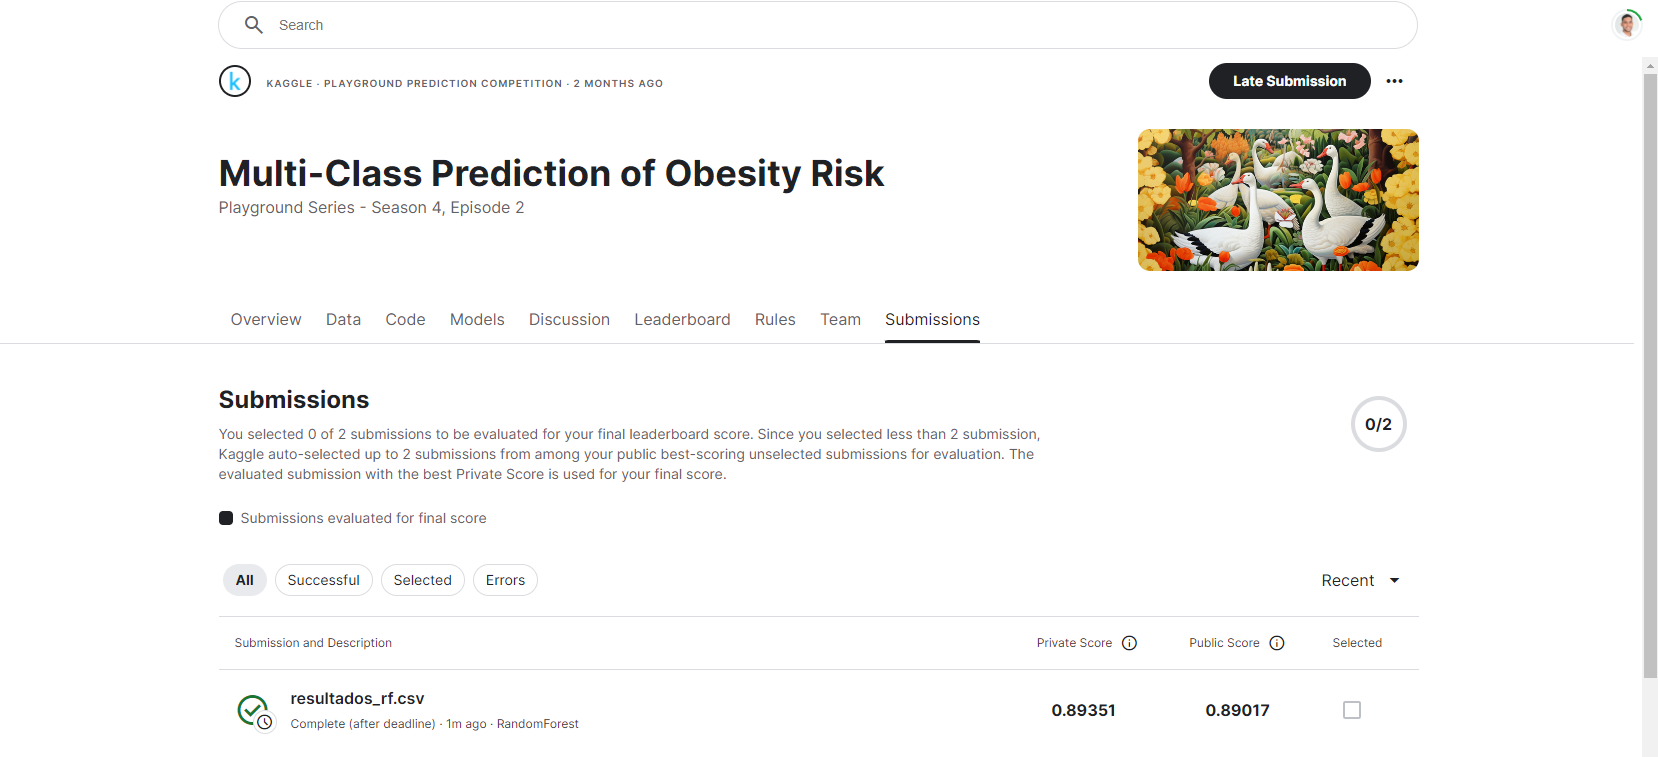